In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Conv1D, BatchNormalization, Activation, Add, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf

In [12]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, sep='\s+')
    return dataframe.values

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3598365463.py:2: SyntaxWarning: invalid escape sequence '\s'
  dataframe = pd.read_csv(filepath, header=None, sep='\s+')


In [13]:
def load_group(filenames, prefix=''):
    loaded = [load_file(prefix + name) for name in filenames]
    loaded = np.dstack(loaded)
    return loaded

In [14]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = [
        'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt',
        'body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt',
        'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt'
    ]
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [15]:
def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/2025-2 MLP/source/UCI HAR Dataset/UCI HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [16]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

In [17]:
X_train, X_val, y_train_one_hot, y_val_one_hot, y_train, y_val = train_test_split(
    trainX, trainy_one_hot, trainy, test_size=0.2, random_state=100
)

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [18]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])
    x_skip = x
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, x_skip])
    return x

In [19]:
def resnet_block(x, filters, kernel_size=3):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    # Add 1x1 convolution to shortcut to match filters if necessary
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

In [20]:
inputs = Input(shape=(n_timesteps, n_features))
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1)
x = resnet_block(x, 64)
x = resnet_block(x, 64)
x = GlobalAveragePooling1D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(n_outputs, activation='softmax')(x)

transformer_resnet_model = Model(inputs, outputs)
transformer_resnet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
transformer_resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 9)    │         18 │ input_layer_1[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 128, 9)    │      9,993 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 9)    │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 128, 9)    │         18 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128, 128)  │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128, 9)    │      1,161 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 128, 9)    │          0 │ dense_3[0][0],    │
│                     │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 64)   │      1,792 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 128, 64)   │        640 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 128, 64)   │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 128, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 64)   │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 128, 64)   │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_5[0][0]  

 Total params: 89,596 (349.98 KB)

 Trainable params: 88,956 (347.48 KB)

 Non-trainable params: 640 (2.50 KB)

In [21]:
model_history = transformer_resnet_model.fit(
    X_train,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 43s 205ms/step - accuracy: 0.7988 - loss: 0.5650 - val_accuracy: 0.6044 - val_loss: 1.0603
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 33s 201ms/step - accuracy: 0.9236 - loss: 0.1879 - val_accuracy: 0.9185 - val_loss: 0.2173
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.9479 - loss: 0.1386 - val_accuracy: 0.7878 - val_loss: 0.6013
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.9528 - loss: 0.1217 - val_accuracy: 0.9457 - val_loss: 0.1202
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9405 - loss: 0.1483 - val_accuracy: 0.6197 - val_loss: 3.2264
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 193ms/step - accuracy: 0.9255 - loss: 0.1894 - val_accuracy: 0.9049 - val_loss: 0.2362
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - accuracy: 0.9505 - loss: 0.1223 - val_accuracy: 0.9525 - val_loss: 0.1179
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.9454 - loss: 0

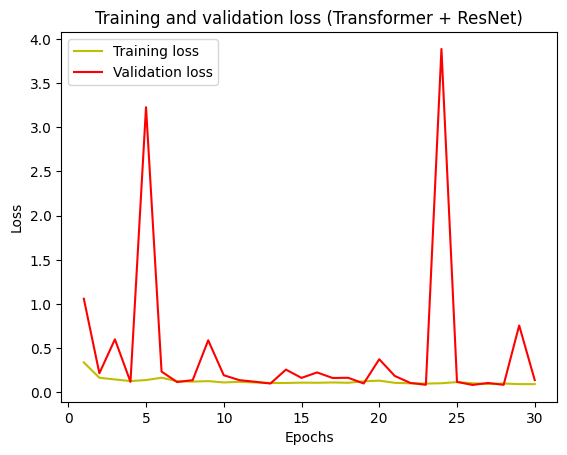

In [22]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (Transformer + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

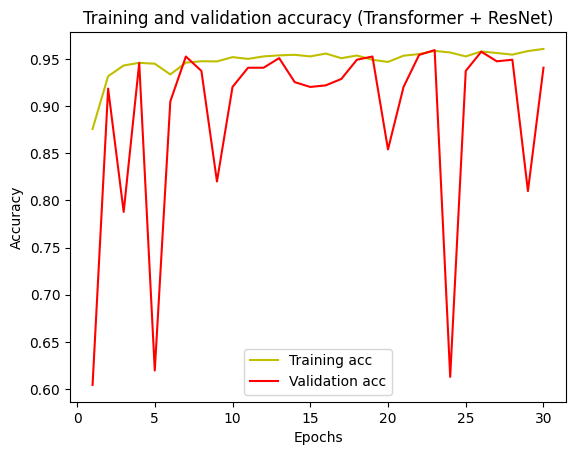

In [23]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (Transformer + ResNet)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step
[[489   1   6   0   0   0]
 [  4 443  24   0   0   0]
 [ 14   7 399   0   0   0]
 [  0   7   0 389  95   0]
 [  0   0   0  52 480   0]
 [  0   0   0   0   0 537]]
0.9287410926365796
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       496
           1       0.97      0.94      0.95       471
           2       0.93      0.95      0.94       420
           3       0.88      0.79      0.83       491
           4       0.83      0.90      0.87       532
           5       1.00      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



<Axes: >

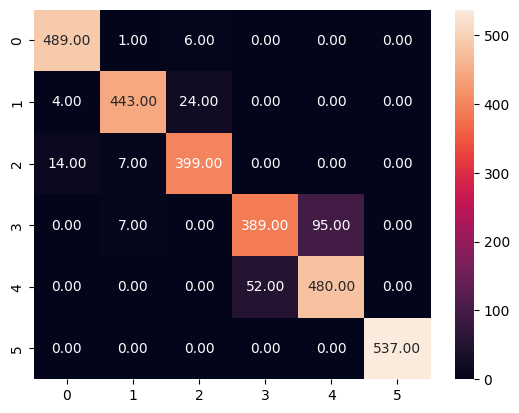

In [24]:
pred = transformer_resnet_model.predict(testX)
pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')